In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassPredictionError
from yellowbrick.style import set_palette
from yellowbrick.contrib.classifier import DecisionViz

In [34]:
def filter_outliers(x2):
    columns = x2.columns.tolist()

    print('Shape before filtering: ', x2.shape)

    for col in columns:
        if col == 'class':continue
        q1 = x2[col].quantile(0.25)
        q3 = x2[col].quantile(0.75)
        iqr = q3 - q1

        filter = (x2[col] >= q1 - 1.5 * iqr) & (x2[col] <= q3 + 1.5 * iqr)
        x2 = x2.loc[filter]

    print('Shape after filtering: ', x2.shape)

    return x2

In [35]:
# Load data from csv file
data = pd.read_csv("star_classification.csv")
data = data.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID', 'u', 'z'], axis = 1)

# Convert Class from string to int
data["class"] = [0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]

# Remove outliers
data = filter_outliers(data)

# Before balancing the features remove class label
x = data.drop(['class'], axis = 1)
y = data.loc[:,'class'].values

# Generate examples for QSO and Star class
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

# Scaling
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

# Train and Test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

Shape before filtering:  (100000, 5)
Shape after filtering:  (90765, 5)
Original dataset shape Counter({0: 59236, 1: 21544, 2: 9985})
Resampled dataset shape Counter({0: 59236, 2: 59236, 1: 59236})


## Optimal Model Training with K-Fold CV

In [36]:
## Optimal hyper parameters for each ML model

best_parameters_log_noreg = {'C': 10000, 'max_iter': 200, 'solver': 'lbfgs'}
best_parameters_log_reg_l1 = {'C': 100, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}
best_parameters_log_reg_l2 = {'C': 5000, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'} 
best_parameters_svm =  {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
best_parameters_xgb = {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000} 
best_parameters_for = {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
best_parameters_nn = {}

In [37]:
def optimal_model_training(x_train, y_train, clf):
    # Doing 5-fold cross validation
    scores = cross_validate(clf, x_train, y_train, scoring='balanced_accuracy', return_estimator=True)

    # Obtaining the estimator with better balanced accuracy
    avg_acc_score = sum(scores['test_score'])/5

    print('Balanced accuracy of each fold - {}'.format(scores['test_score']))
    print('Avg balanced accuracy : {}'.format(avg_acc_score))
    
    best_estimator = scores['estimator'][np.argmax(scores['test_score'])]

    return best_estimator

In [38]:
def obtain_performance_metrics(best_estimator, x_test, y_test):
    # Prediction using the best estimator
    y_pred = best_estimator.predict(x_test)

    # Performance Metrics and Confusion Matrix
    print("Classification Report: ")
    print()
    target_names = ['GALAXY', 'STAR', 'QUASAR']
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("Balanced accuracy score: ")
    print(balanced_accuracy_score(y_test, y_pred))

    print("\nConfusion Matrix: ")
    print()
    matrix = confusion_matrix(y_test, y_pred)
    sea.heatmap(matrix, cmap="PuBu", annot=True, linewidths=0.5, fmt= 'd')
    plt.show()

In [39]:
def obtain_roc_curve(clf, x_train, y_train, x_test, y_test):
    target_names = ['GALAXY', 'STAR', 'QUASAR']

    visualizer = ROCAUC(clf, classes=target_names)

    set_palette('bold')

    print("ROC Curve: ")
    print()
    
    visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure

In [40]:
def obtain_precision_recall_curve(clf, x_train, y_train, x_test, y_test):
    visualizer = PrecisionRecallCurve(clf)

    print("Precision-Recall Curve: ")
    print()
    
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()

In [41]:
def show_decision_boundary(clf, x_train, y_train, x_test, y_test, title, features):
    viz = DecisionViz(
        clf, title=title,
        features=features, classes=['GALAXY', 'STAR', 'QUASAR']
    )

    viz.fit(x_train, y_train)
    viz.draw(x_test, y_test)
    viz.show()

In [42]:
def show_class_prediction_error(clf, x_train, y_train, x_test, y_test):
    visualizer = ClassPredictionError(clf, classes=['GALAXY', 'STAR', 'QUASAR'])

    set_palette('pastel')

    visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Draw visualization

#### Logistic Regression Without Regularization

Balanced accuracy of each fold - [0.93745457 0.93540592 0.93535757 0.93636719 0.93684746]
Avg balanced accuracy : 0.936286541888198
Classification Report: 

              precision    recall  f1-score   support

      GALAXY       0.89      0.92      0.90     17707
        STAR       0.99      1.00      1.00     17742
      QUASAR       0.93      0.88      0.91     17864

    accuracy                           0.94     53313
   macro avg       0.94      0.94      0.94     53313
weighted avg       0.94      0.94      0.94     53313

Balanced accuracy score: 
0.9355288249628871

Confusion Matrix: 



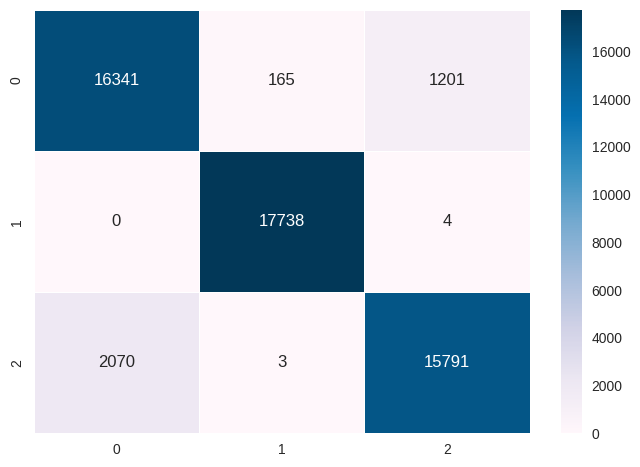

ROC Curve: 



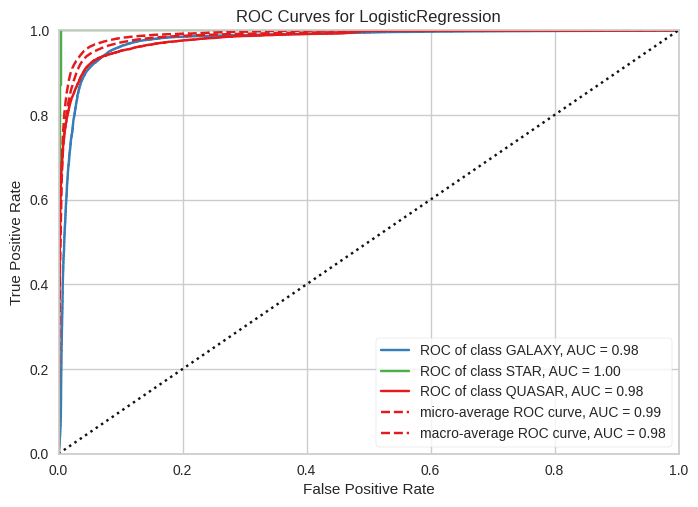

Precision-Recall Curve: 



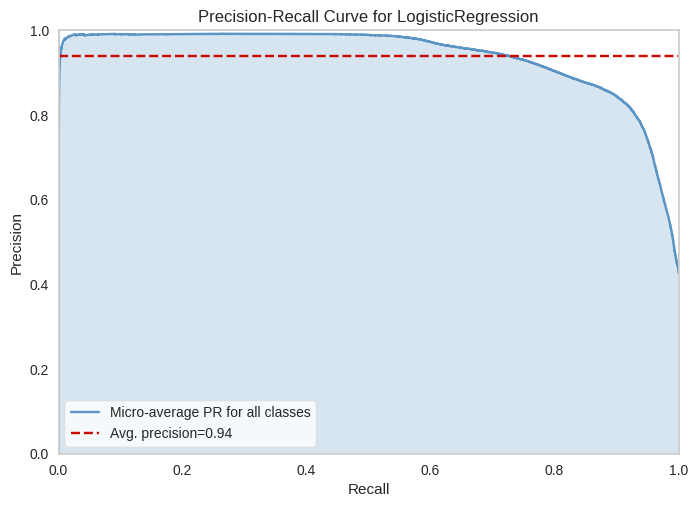

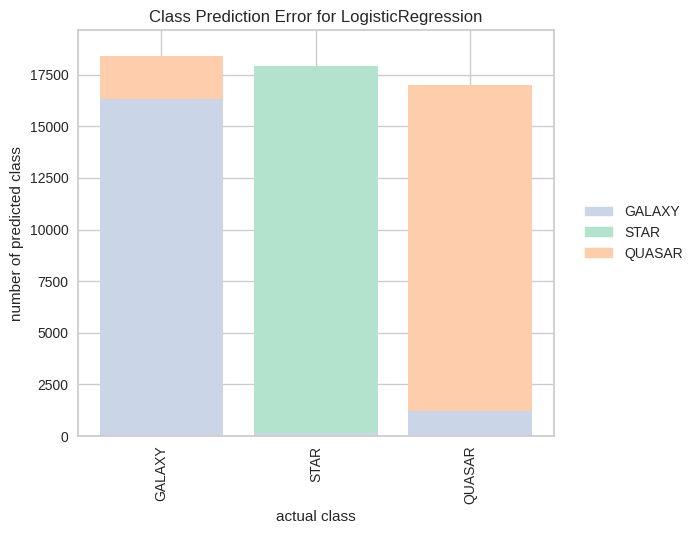

In [45]:
clf = LogisticRegression()
clf.set_params(**best_parameters_log_noreg)
best_clf = optimal_model_training(x_train, y_train, clf)

obtain_performance_metrics(best_clf, x_test, y_test)
obtain_roc_curve(best_clf, x_train, y_train, x_test, y_test)
obtain_precision_recall_curve(best_clf, x_train, y_train, x_test, y_test)

#show_decision_boundary(best_clf, x_train[:, [1,3]], y_train, x_test[:, [1,3]], y_test, "Log without Reg", ['redshift', 'r'])
#show_decision_boundary(best_clf, x_train[:, [1,2]], y_train, x_test[:, [1,2]], y_test, "Log without Reg", ['i', 'r'])

show_class_prediction_error(best_clf, x_train, y_train, x_test, y_test)

#### Logistic Regression With L1 Regularization

Balanced accuracy of each fold - [0.93709331 0.93508487 0.93507665 0.9361665  0.93656654]
Avg balanced accuracy : 0.9359975728680089
Classification Report: 

              precision    recall  f1-score   support

      GALAXY       0.89      0.92      0.90     17707
        STAR       0.99      1.00      0.99     17742
      QUASAR       0.93      0.88      0.91     17864

    accuracy                           0.93     53313
   macro avg       0.94      0.94      0.93     53313
weighted avg       0.94      0.93      0.93     53313

Balanced accuracy score: 
0.9350207168441612

Confusion Matrix: 



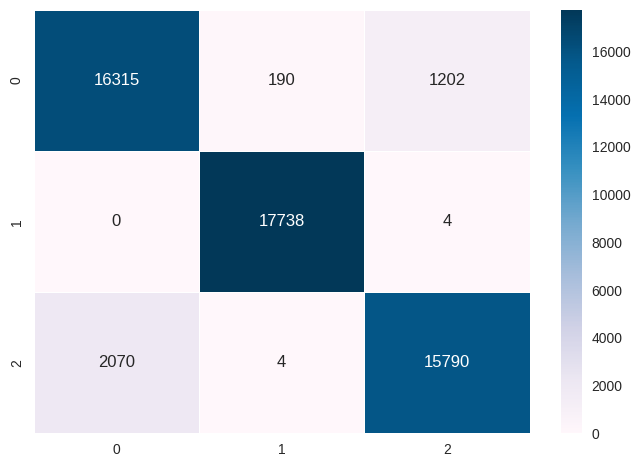

ROC Curve: 



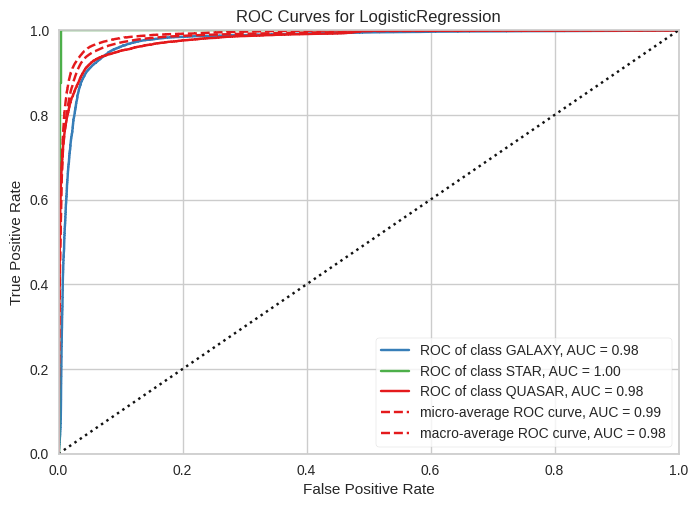

Precision-Recall Curve: 



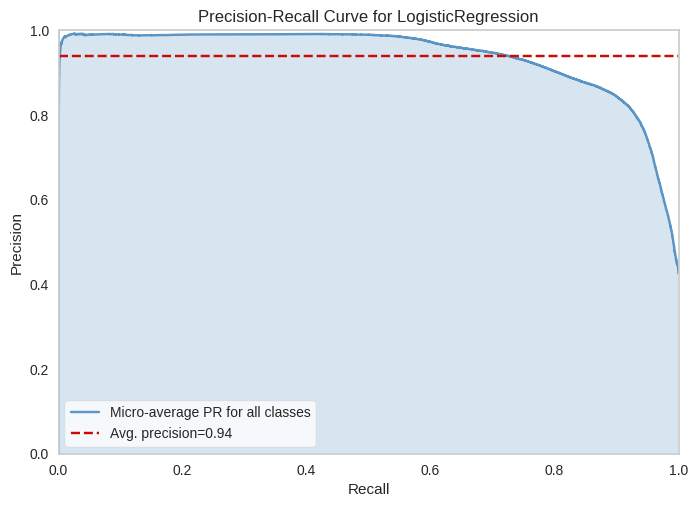

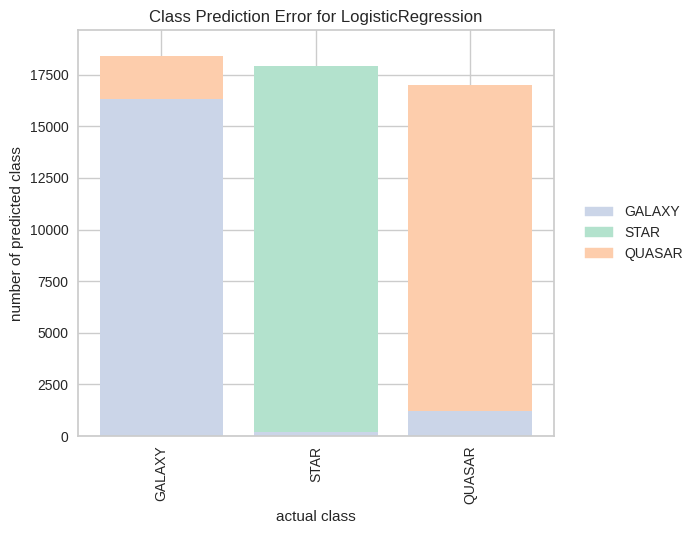

In [46]:
clf = LogisticRegression()
clf.set_params(**best_parameters_log_reg_l1)
best_clf = optimal_model_training(x_train, y_train, clf)

obtain_performance_metrics(best_clf, x_test, y_test)
obtain_roc_curve(best_clf, x_train, y_train, x_test, y_test)
obtain_precision_recall_curve(best_clf, x_train, y_train, x_test, y_test)

#show_decision_boundary(best_clf, x_train[:, [1,3]], y_train, x_test[:, [1,3]], y_test, "Log without Reg", ['redshift', 'r'])
#show_decision_boundary(best_clf, x_train[:, [1,2]], y_train, x_test[:, [1,2]], y_test, "Log without Reg", ['i', 'r'])

show_class_prediction_error(best_clf, x_train, y_train, x_test, y_test)

#### Logistic Regression With L2 Regularization

#### SVM

Balanced accuracy of each fold - [0.96198152 0.96101946 0.96053243 0.9615009  0.96266686]
Avg balanced accuracy : 0.9615402352994942
Classification Report: 

              precision    recall  f1-score   support

      GALAXY       0.93      0.96      0.94     17707
        STAR       0.99      1.00      0.99     17742
      QUASAR       0.96      0.93      0.95     17864

    accuracy                           0.96     53313
   macro avg       0.96      0.96      0.96     53313
weighted avg       0.96      0.96      0.96     53313

Balanced accuracy score: 
0.9607973893448075

Confusion Matrix: 



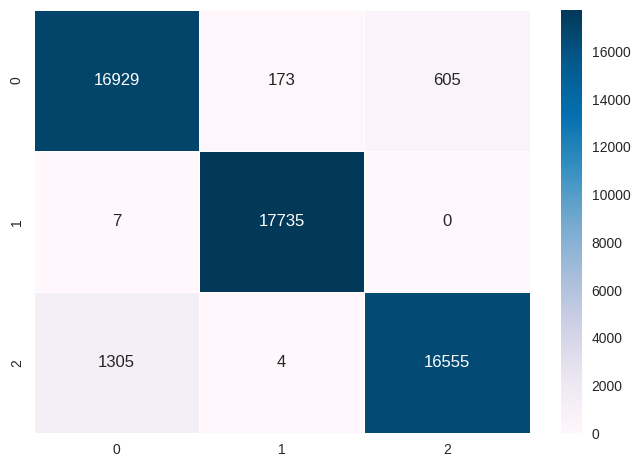

ROC Curve: 



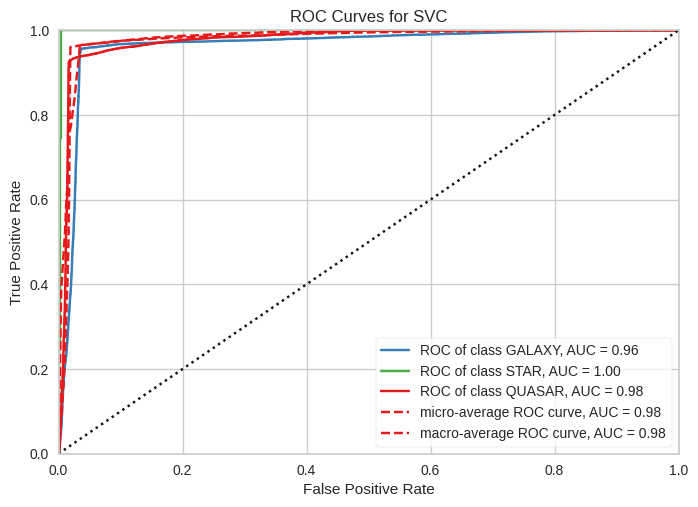

Precision-Recall Curve: 



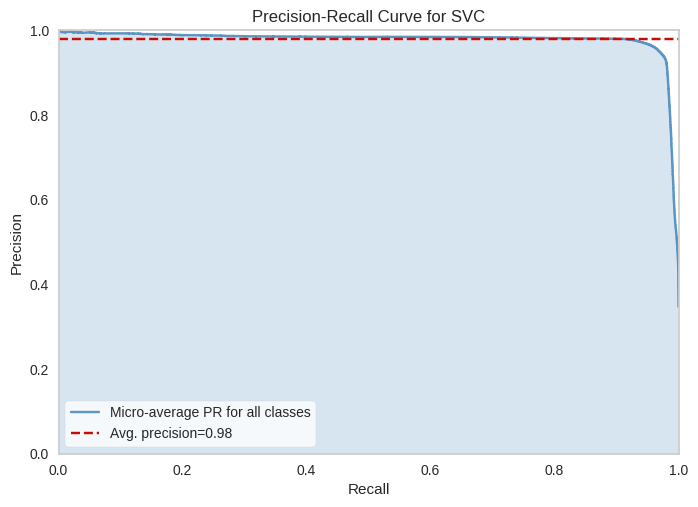

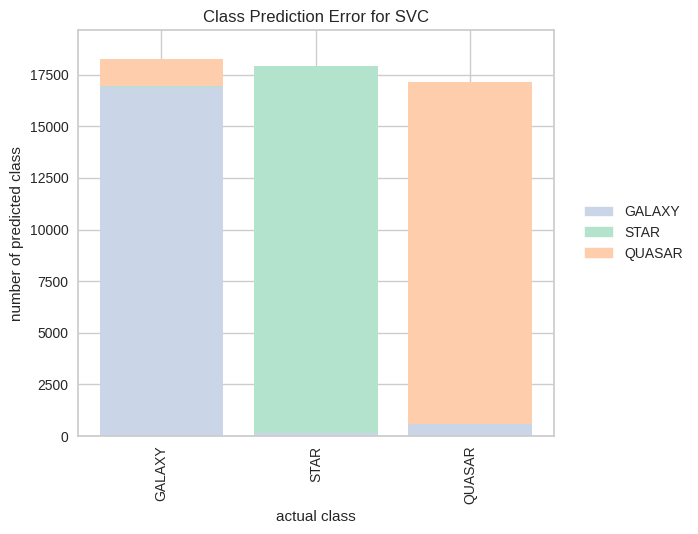

In [47]:
clf = SVC()
clf.set_params(**best_parameters_svm)
best_clf = optimal_model_training(x_train, y_train, clf)

obtain_performance_metrics(best_clf, x_test, y_test)
obtain_roc_curve(best_clf, x_train, y_train, x_test, y_test)
obtain_precision_recall_curve(best_clf, x_train, y_train, x_test, y_test)

#show_decision_boundary(best_clf, x_train[:, [1,3]], y_train, x_test[:, [1,3]], y_test, "Log without Reg", ['redshift', 'r'])
#show_decision_boundary(best_clf, x_train[:, [1,2]], y_train, x_test[:, [1,2]], y_test, "Log without Reg", ['i', 'r'])

show_class_prediction_error(best_clf, x_train, y_train, x_test, y_test)

#### XG Boost

#### Random Forest

#### Neural Network